# 📚 Projet Fine-Tuning GPT2 Small Arabic + RAG (Question-Réponse)

## 🗂️ Données utilisées
- **Sources** : `arabicmmlu.csv`, `alghafa.csv`, `madinahqa.csv`, `aratrust.csv`
- **Format cible** : Génératif (`### سؤال:` ... `### الإجابة:`)
- **Nombre d'exemples** : ~16,000
- **Split** : 90% entraînement, 10% test

---

## 🔄 Pipeline de Fine-Tuning

```plaintext
CSV ➝ JSONL ➝ HuggingFace Datasets ➝ Tokenisation (max_length=512)
     ➝ GPT2-Small-Arabic + LoRA (QLoRA désactivée)
     ➝ Fine-Tuning via SFTTrainer (4K steps, 2e-4 LR)
     ➝ Sauvegarde modèle fine-tuné (.bin + tokenizer)


## 📊 Résultats d’Évaluation du Modèle Fine-Tuné (Génération QA Arabe)

| Métrique         | Valeur   |
|------------------|----------|
| **BLEU**         | 0.0011   |
| **ROUGE-L**      | 0.0000   |
| **Exact Match**  | 0.0000   |
| **F1**           | 0.0640   |


---

# 📚 Résultats d'Évaluation du Retriever FAISS


| Métrique              | Valeur |
|-----------------------|--------|
| **Recall@5**          | 0.8600 |
| **MRR@5**             | 0.7887 |
| **Exact Match (EM)**  | 0.0000 |
| **Word-level F1**     | 0.6113 |

---

# 📊 Résultats de l'Évaluation de la Génération du Modèle

| Métrique              | Valeur  |
|-----------------------|---------|
| **Exact Match:**  |  0.0006|
| **Word-level F1**     |  0.0212  |
| **ROUGE-L   **           | 0.0000  |
| **BERTScore-F1 **      | 0.5226 |



# 📦 Installation des dépendances

**transformers**, **datasets**, **trl**, **peft**, **bitsandbytes**, **accelerate**

Montage de **Google Drive**

In [ ]:
pip install transformers accelerate peft bitsandbytes datasets trl


prepare les doner

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 📝 Préparation des données

1. Chargement des fichiers CSV : arabicmmlu.csv, alghafa.csv, madinahqa.csv, aratrust.csv.

2. Construction des prompts (format ### سؤال / ### الإجابة)

3. Sauvegarde en fichier .jsonl

# example **DATA**

In [ ]:
import json

# Chemin vers ton fichier
file_path = "/content/drive/MyDrive/prepared_arabic_qa_generation.jsonl"

# Lire les 5 premiers exemples
with open(file_path, "r", encoding="utf-8") as f:
    for i in range(5):
        line = f.readline()
        if not line:
            break
        example = json.loads(line)
        print(f"\n🔹 Exemple {i+1} :\n")
        print(example["text"])
        print("="*50)



🔹 Exemple 1 :

### سؤال:
كم عدد سور القرآن الكريم؟
أ. 111  ب. 112  ج. 113  د. 114  هـ.

### الإجابة:
كم عدد سور القرآن الكريم؟ الإجابة هي: 114.

🔹 Exemple 2 :

### سؤال:
في أي الأيام خلق سيدنا آدم عليه السلام؟
أ. يوم السبت  ب. يوم الاثنين  ج. يوم الأربعاء  د. يوم الجمعة  هـ.

### الإجابة:
في أي الأيام خلق سيدنا آدم عليه السلام؟ الإجابة هي: يوم الجمعة.

🔹 Exemple 3 :

### سؤال:
كم عدد السنوات التي نام فيها أهل الكهف؟
أ. 300 سنة  ب. 309 سنوات  ج. 400 سنة  د. 409 سنوات  هـ.

### الإجابة:
كم عدد السنوات التي نام فيها أهل الكهف؟ الإجابة هي: 309 سنوات.

🔹 Exemple 4 :

### سؤال:
اسم أول صحابي قرأ القرآن جهرة؟
أ. عبد الله بن مسعود  ب. عبد الله بن عباس  ج. عبد الله بن عمرو بن العاص  د. عبد الله بن الزبير  هـ.

### الإجابة:
اسم أول صحابي قرأ القرآن جهرة؟ الإجابة هي: عبد الله بن مسعود.

🔹 Exemple 5 :

### سؤال:
من هي أخر زوجات النبي التي توفيت؟
أ. السيدة زينب بنت جحش  ب. السيدة عائشة بنت أبي بكر  ج. السيدة أم سلمة  د. السيدة سودة بنت زمعة  هـ.

### الإجابة:
من هي أخر زوجات النبي التي توفيت؟ الإج

# Chargement du dataset HuggingFace

1. Chargement avec load_dataset()

2. Split en train / test

In [ ]:
import json
from datasets import Dataset

# Charger manuellement les lignes du fichier JSONL
file_path = "/content/drive/MyDrive/prepared_arabic_qa_generation.jsonl"
data = []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line.strip())
        data.append(item)

# Créer un dataset HuggingFace
dataset = Dataset.from_list(data)

# Split train / test (90/10)
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# 🔍 Exemple
print(train_dataset[0])


{'text': '### سؤال:\nما التكيف الذي يساعد الجمل على حماية نفسه من تأثير رمال الصحراء؟\nأ. الشفاه الغليظة  ب. الوبر  ج. الرموش الطويلة  د. السنام\n\n### الإجابة:\nما التكيف الذي يساعد الجمل على حماية نفسه من تأثير رمال الصحراء؟ الإجابة هي: الوبر.'}


# Chargement du modèle model_name = "akhooli/gpt2-small-arabic"

1. Tokenizer

2. Quantization 4-bit (BitsAndBytesConfig)

3. Configuration LoRA (q_proj, v_proj)

4. Affichage des paramètres LoRA entraînables

In [ ]:
!pip uninstall -y bitsandbytes
!pip install bitsandbytes==0.41.1
!pip install transformers accelerate peft


Found existing installation: bitsandbytes 0.41.1
Uninstalling bitsandbytes-0.41.1:
  Successfully uninstalled bitsandbytes-0.41.1
  Using cached bitsandbytes-0.41.1-py3-none-any.whl.metadata (9.8 kB)
Using cached bitsandbytes-0.41.1-py3-none-any.whl (92.6 MB)


In [ ]:
!pip install -q peft transformers


In [ ]:
# 🔹 Étape 1 : install libs minimales
!pip install -q transformers peft datasets

# 🔹 Étape 2 : Charger modèle normal (sans quantization)
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model
import torch

model_name = "akhooli/gpt2-small-arabic"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # ou "cpu"
    torch_dtype=torch.float32  # 👈 compatible Colab gratuit
)

# 🔹 Étape 3 : Appliquer LoRA classique (pas QLoRA)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["c_attn"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at akhooli/gpt2-small-arabic and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a dow

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.23643136409814364


# Tokenisation des données

1.Tokenisation avec padding et truncation (max_length=512)

2.Suppression de la colonne text

In [ ]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])


Map:   0%|          | 0/14531 [00:00<?, ? examples/s]

Map:   0%|          | 0/1615 [00:00<?, ? examples/s]

# 🏋️ Configuration de l’entraînement

1. Paramètres TrainingArguments

2. Utilisation de SFTTrainer

3. Nombre de steps : 500, puis 1000

In [ ]:
!pip uninstall -y transformers trl peft accelerate
!pip install transformers==4.31.0 trl==0.4.7 peft==0.4.0 accelerate==0.21.0


Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
Found existing installation: accelerate 1.6.0
Uninstalling accelerate-1.6.0:
  Successfully uninstalled accelerate-1.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1


In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=10,
    max_steps=4000,                     # ← nombre total d'étapes
    learning_rate=2e-4,
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    save_total_limit=2,
    fp16=True,
    report_to="none",                  # ← pas de tracking externe
    optim="adamw_torch"                # ✅ utilise AdamW PyTorch (recommandé)
)


Lancement du fine-tuning

In [ ]:
def format_qa(example):
    question = example.get("question", "").strip()
    answer = example.get("answer", "").strip()
    return {
        "text": f"### سؤال:\n{question}\n### الإجابة:\n{answer}"
    }


In [ ]:
from datasets import DatasetDict

# Supposons que dataset = DatasetDict avec train/test
# Vérifie les colonnes présentes :
print(dataset["train"].column_names)  # doit contenir 'question' et 'answer'

# Appliquer la fonction sur chaque split
dataset_formatted = DatasetDict({
    "train": dataset["train"].map(format_qa),
    "test": dataset["test"].map(format_qa)
})


['text']


Map:   0%|          | 0/14531 [00:00<?, ? examples/s]

Map:   0%|          | 0/1615 [00:00<?, ? examples/s]

In [ ]:
print(dataset_formatted["train"][0]["text"])  # doit afficher le prompt formaté


### سؤال:

### الإجابة:



In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset_formatted["train"],
    eval_dataset=dataset_formatted["test"],
    args=training_args,
    dataset_text_field="text"
)


/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/14531 [00:00<?, ? examples/s]

Map:   0%|          | 0/1615 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
import time

start_time = time.time()

# 🔁 Lancer l'entraînement
trainer.train()

end_time = time.time()

# 🕒 Afficher la durée
elapsed = end_time - start_time
minutes = elapsed // 60
seconds = elapsed % 60

print(f"\n⏱️ Temps total d'entraînement : {int(minutes)} min {int(seconds)} sec")


/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1301: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  new_forward = torch.cuda.amp.autocast(dtype=torch.float16)(model_forward_func)


Step,Training Loss,Validation Loss
100,0.025200,0.000042
200,0.027500,0.000032
300,0.020700,0.000044
400,0.016800,0.000026
500,0.019100,0.000024
600,0.014400,0.000027
700,0.014500,0.000027
800,0.008700,0.000025
900,0.002600,0.000025
1000,0.017900,0.000030



⏱️ Temps total d'entraînement : 13 min 8 sec


# Visualisation de la perte

In [ ]:
# 📦 Sauvegarde du modèle fine-tuné
save_path = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\n✅ Modèle et tokenizer sauvegardés dans : {save_path}")



✅ Modèle et tokenizer sauvegardés dans : /content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# 📦 Chemin de sauvegarde dans Google Drive
save_path = "/content/drive/MyDrive/final_model_gptneo_arabic_gen"

# ✅ Sauvegarder le modèle
model.save_pretrained(save_path)

# ✅ Sauvegarder le tokenizer
tokenizer.save_pretrained(save_path)

print(f"\n✅ Modèle complet sauvegardé dans : {save_path}")



✅ Modèle complet sauvegardé dans : /content/drive/MyDrive/final_model_gptneo_arabic_gen


Courbes **training_loss** et **validation_loss**

<ipython-input-1-bae78357a4bd>:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-bae78357a4bd>:34: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-bae78357a4bd>:34: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


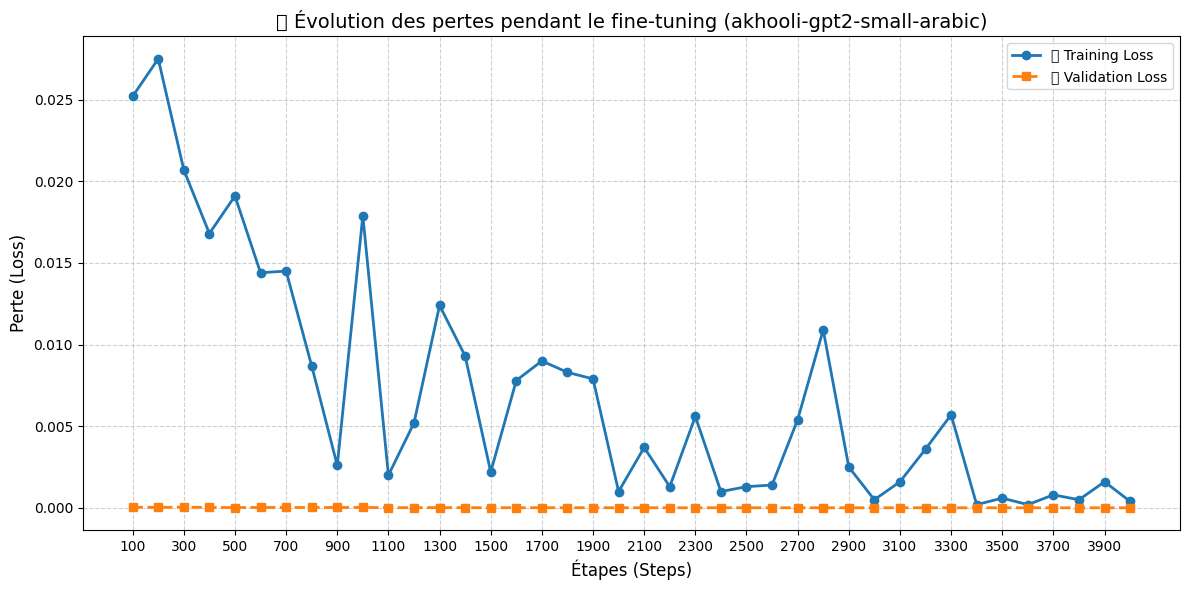

<ipython-input-1-bae78357a4bd>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


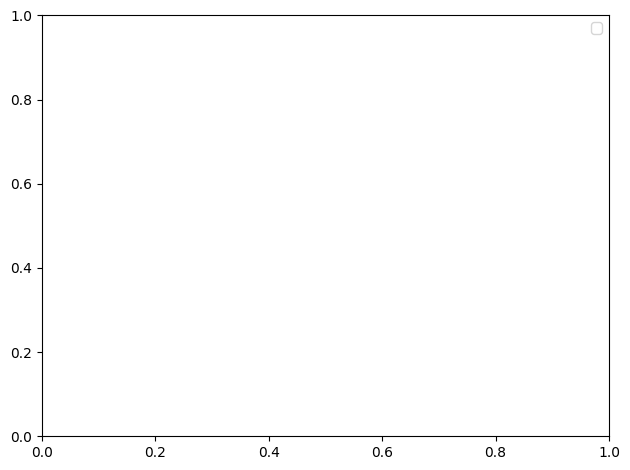

In [ ]:
import matplotlib.pyplot as plt

# Étapes d'entraînement
steps = list(range(100, 4100, 100))

# Pertes d'entraînement (Training Loss)
training_loss = [
    0.025200, 0.027500, 0.020700, 0.016800, 0.019100, 0.014400, 0.014500, 0.008700,
    0.002600, 0.017900, 0.002000, 0.005200, 0.012400, 0.009300, 0.002200, 0.007800,
    0.009000, 0.008300, 0.007900, 0.001000, 0.003700, 0.001300, 0.005600, 0.001000,
    0.001300, 0.001400, 0.005400, 0.010900, 0.002500, 0.000500, 0.001600, 0.003600,
    0.005700, 0.000200, 0.000600, 0.000200, 0.000800, 0.000500, 0.001600, 0.000400
]

# Pertes de validation (Validation Loss)
validation_loss = [
    0.000042, 0.000032, 0.000044, 0.000026, 0.000024, 0.000027, 0.000027, 0.000025,
    0.000025, 0.000030, 0.000018, 0.000015, 0.000018, 0.000015, 0.000014, 0.000012,
    0.000012, 0.000013, 0.000012, 0.000011, 0.000010, 0.000009, 0.000008, 0.000011,
    0.000010, 0.000010, 0.000010, 0.000009, 0.000008, 0.000008, 0.000009, 0.000009,
    0.000009, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008
]

# Tracé des courbes
plt.figure(figsize=(12, 6))
plt.plot(steps, training_loss, marker='o', label='📘 Training Loss', linewidth=2)
plt.plot(steps, validation_loss, marker='s', label='🧪 Validation Loss', linewidth=2, linestyle='--')
plt.xlabel("Étapes (Steps)", fontsize=12)
plt.ylabel("Perte (Loss)", fontsize=12)
plt.title("📉 Évolution des pertes pendant le fine-tuning (akhooli-gpt2-small-arabic)", fontsize=14)
plt.xticks(steps[::2])  # pour espacer les ticks sur l’axe x
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

plt.legend()
plt.tight_layout()
plt.show()


 Sauvegarde automatique du modèle

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# 🔹 1. Charger le modèle de base
base_model = AutoModelForCausalLM.from_pretrained("akhooli/gpt2-small-arabic")

# 🔹 2. Charger le tokenizer depuis le dossier sauvegardé
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic")

# 🔹 3. Charger l’adaptateur LoRA sur le modèle de base
model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic")

# 🔹 4. Utilisation
from transformers import pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
prompt = "### سؤال:\nمن هو أول خليفة في الإسلام؟\n### الإجابة:\n"
result = pipe(prompt, max_new_tokens=50, do_sample=False)
print(result[0]["generated_text"])


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausal

### سؤال:
من هو أول خليفة في الإسلام؟
### الإجابة:

#### الإجابة:


### الإجابة:


 الإجابة:

### الإجابة:


 الإجابة:


### الإجابة:


 الإجابة:


##


In [ ]:
from transformers import pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
print(pipe("### سؤال:\nما هو اسم أطول نهر في العالم؟\n### الإجابة:\n")[0]["generated_text"])


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausal

### سؤال:
ما هو اسم أطول نهر في العالم؟
### الإجابة:

#### الإجابة:


### الإجابة:


 الإجابة:


#### الإجابة:


# Évaluation du modèle fine-tuné

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Nom de ton modèle de base (sur Hugging Face ou local)
model_name = "akhooli/gpt2-small-arabic"

# Chemin de sortie (où sauvegarder les fichiers du tokenizer et la config du modèle)
output_dir = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"

# 1. Charger et sauvegarder le tokenizer complet
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_dir)

# 2. Charger et sauvegarder la config du modèle
model = AutoModelForCausalLM.from_pretrained(model_name)
model.config.to_json_file(f"{output_dir}/config.json")


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

# Nom du modèle de base HuggingFace
model_name = "akhooli/gpt2-small-arabic"

# Chemin du répertoire où tu veux sauvegarder les fichiers
output_dir = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"
os.makedirs(output_dir, exist_ok=True)

# 1. Sauvegarder le tokenizer complet
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_dir)

# 2. Sauvegarder la configuration et les poids du modèle de base
model = AutoModelForCausalLM.from_pretrained(model_name)
model.save_pretrained(output_dir)  # inclut config.json + pytorch_model.bin

# 3. Sauvegarder un README.md
readme_path = os.path.join(output_dir, "README.md")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write("# Fine-tuned akhooli/gpt2-small-arabic\n\nThis directory contains all necessary files to load the model with PEFT (QLoRA/LoRA).")

# 4. Vérification facultative : liste les fichiers présents
print("✅ Fichiers générés :")
for fname in os.listdir(output_dir):
    print("-", fname)


✅ Fichiers générés :
- README.md
- adapter_model.bin
- adapter_config.json
- tokenizer_config.json
- special_tokens_map.json
- vocab.json
- merges.txt
- tokenizer.json
- config.json
- generation_config.json
- model.safetensors


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"))


['README.md', 'adapter_model.bin', 'adapter_config.json', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.json', 'merges.txt', 'tokenizer.json', 'config.json']


In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

output = pipe("### سؤال:\nما هي عاصمة المغرب؟\n### الإجابة:\n", max_new_tokens=50)
print(output[0]["generated_text"])


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'O

### سؤال:
ما هي عاصمة المغرب؟
### الإجابة:

#### الإجابة:


### الإجابة:


 الإجابة:

 الإجابة:


### الإجابة:


 الإجابة:


### الإجابة:


 الإجابة:


In [ ]:
!pip install rouge-score --quiet


In [ ]:
!pip install rouge-score nltk --quiet


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
!pip uninstall -y bitsandbytes
!pip install bitsandbytes==0.41.1  # compatible CUDA 11.x - 12.x


Found existing installation: bitsandbytes 0.41.1
Uninstalling bitsandbytes-0.41.1:
  Successfully uninstalled bitsandbytes-0.41.1
  Using cached bitsandbytes-0.41.1-py3-none-any.whl.metadata (9.8 kB)
Using cached bitsandbytes-0.41.1-py3-none-any.whl (92.6 MB)


In [ ]:
!pip uninstall -y bitsandbytes


Found existing installation: bitsandbytes 0.41.1
Uninstalling bitsandbytes-0.41.1:
  Successfully uninstalled bitsandbytes-0.41.1


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_path = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained(model_path)


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to

In [ ]:
import json
import nltk
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from nltk.tokenize import wordpunct_tokenize as tokenize_arabic
import torch

# === Téléchargement des ressources NLTK ===
nltk.download('punkt')

# === 1. Charger les données ===
jsonl_path = "/content/drive/MyDrive/prepared_arabic_qa_generation.jsonl"
with open(jsonl_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

prompts, true_answers = [], []
for item in data:
    if "### الإجابة:" in item["text"]:
        parts = item["text"].split("### الإجابة:")
        prompt = parts[0] + "### الإجابة:\n"
        answer = parts[1].strip()
        prompts.append(prompt)
        true_answers.append(answer)
    if len(prompts) >= 100:
        break

# === 2. Charger le modèle fine-tuné en mode float32 pour éviter bitsandbytes
model_path = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Utilisation du pipeline en CPU ou GPU
device = 0 if torch.cuda.is_available() else -1
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=device)

# === 3. Générer les réponses
print("⏳ Génération des réponses...")
predicted_answers = []
for prompt in tqdm(prompts):
    output = pipe(prompt, max_new_tokens=50, do_sample=False, temperature=0.0)
    generated = output[0]["generated_text"]
    response = generated.split("### الإجابة:")[-1].strip()
    predicted_answers.append(response)

# === 4. Évaluation
def evaluate_nlp(predictions, references):
    smooth = SmoothingFunction().method1
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    bleu_scores, rouge_scores, exact_matches, f1s = [], [], [], []

    for pred, ref in zip(predictions, references):
        pred_tokens = tokenize_arabic(pred)
        ref_tokens = tokenize_arabic(ref)

        bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth)
        bleu_scores.append(bleu)

        r_score = rouge.score(ref, pred)['rougeL'].fmeasure
        rouge_scores.append(r_score)

        exact_matches.append(int(pred.strip() == ref.strip()))

        common = set(pred_tokens) & set(ref_tokens)
        if pred_tokens and ref_tokens:
            precision = len(common) / len(pred_tokens)
            recall = len(common) / len(ref_tokens)
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        else:
            f1 = 0
        f1s.append(f1)

    return {
        "BLEU": sum(bleu_scores) / len(bleu_scores),
        "ROUGE-L": sum(rouge_scores) / len(rouge_scores),
        "Exact Match": sum(exact_matches) / len(exact_matches),
        "F1": sum(f1s) / len(f1s)
    }

# === 5. Affichage des résultats
metrics = evaluate_nlp(predicted_answers, true_answers)

print("\n📊 Résultats d’évaluation :")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


⏳ Génération des réponses...


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 10%|█         | 10/100 [00:11<01:14,  1.20it/s]/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


📊 Résultats d’évaluation :
BLEU: 0.0011
ROUGE-L: 0.0000
Exact Match: 0.0000
F1: 0.0640


## test

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# === Charger le modèle fine-tuné ===
model_path = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"

model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)





In [ ]:
from transformers import pipeline

# Pipeline avec le modèle fine-tuné
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

# Prompt au bon format (conforme à l'entraînement)
prompt = """### سؤال:
كم عدد سور القرآن الكريم؟
أ. 111  ب. 112  ج. 113  د. 114  هـ.

### الإجابة:
"""

# Génération de la réponse
output = pipe(
    prompt,
    max_new_tokens=50,
    do_sample=False,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.2
)

# Affichage
print("🧪 Réponse générée :\n")
print(output[0]["generated_text"])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🧪 Réponse générée :

### سؤال:
كم عدد سور القرآن الكريم؟
أ. 111  ب. 112  ج. 113  د. 114  هـ.

### الإجابة:

### الإجابة:


### الإجابة:


### الإجابة:


### الإجابة:


 الإجابة:


### الإجابة:


### الإجابة


In [ ]:
from transformers import pipeline

# Pipeline avec le modèle fine-tuné
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")
prompt = """### تعليمات:
أجب فقط بإجابة نهائية مباشرة بدون شرح أو تكرار، وبصيغـة: "الإجابة هي: ...." دون أي إضافات.

### سؤال:
في أي الأيام خلق سيدنا آدم عليه السلام؟
أ. يوم السبت  ب. يوم الاثنين  ج. يوم الأربعاء  د. يوم الجمعة  هـ.

### الإجابة:
الإجابة هي:"""







output = pipe(
    prompt,
    max_new_tokens=20,
    do_sample=False,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.3
)

print("🧪 Réponse générée :\n")
print(output[0]["generated_text"])




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🧪 Réponse générée :

### تعليمات:
أجب فقط بإجابة نهائية مباشرة بدون شرح أو تكرار، وبصيغـة: "الإجابة هي: ...." دون أي إضافات.

### سؤال:
في أي الأيام خلق سيدنا آدم عليه السلام؟
أ. يوم السبت  ب. يوم الاثنين  ج. يوم الأربعاء  د. يوم الجمعة  هـ.

### الإجابة:
الإجابة هي:

#### الإجابة:

### الإجابة:

###


In [ ]:
from transformers import pipeline

# Pipeline avec le modèle fine-tuné
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")
prompt = """### تعليمات:
أجب فقط بإجابة نهائية بصيغة: "الإجابة هي: ..." بدون شرح أو تكرار أو جملة إضافية.

### سؤال:
من هو أول رئيس للجمهورية الجزائرية بعد الاستقلال؟
أ. بن بلة  ب. الشاذلي بن جديد  ج. هواري بومدين  د. عبد العزيز بوتفليقة  هـ.

### الإجابة:
الإجابة هي: بن بلة.

### سؤال:
في أي الأيام خلق سيدنا آدم عليه السلام؟
أ. يوم السبت  ب. يوم الاثنين  ج. يوم الأربعاء  د. يوم الجمعة  هـ.

### الإجابة:
الإجابة هي:"""








output = pipe(
    prompt,
    max_new_tokens=20,
    do_sample=False,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.3
)

print("🧪 Réponse générée :\n")
print(output[0]["generated_text"])




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🧪 Réponse générée :

### تعليمات:
أجب فقط بإجابة نهائية بصيغة: "الإجابة هي: ..." بدون شرح أو تكرار أو جملة إضافية.

### سؤال:
من هو أول رئيس للجمهورية الجزائرية بعد الاستقلال؟
أ. بن بلة  ب. الشاذلي بن جديد  ج. هواري بومدين  د. عبد العزيز بوتفليقة  هـ.

### الإجابة:
الإجابة هي: بن بلة.

### سؤال:
في أي الأيام خلق سيدنا آدم عليه السلام؟
أ. يوم السبت  ب. يوم الاثنين  ج. يوم الأربعاء  د. يوم الجمعة  هـ.

### الإجابة:
الإجابة هي:

#### الإجابة:

### الإجابة:

###


In [ ]:
from transformers import pipeline

# Pipeline avec le modèle fine-tuné
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")
prompt = """### تعليمات:
أجب فقط بإجابة نهائية بصيغة: "الإجابة هي: ..." بدون شرح أو تكرار أو جملة إضافية.

### سؤال:
من هو أول رئيس للجمهورية الجزائرية بعد الاستقلال؟
أ. بن بلة  ب. الشاذلي بن جديد  ج. هواري بومدين  د. عبد العزيز بوتفليقة  هـ.

### الإجابة:
الإجابة هي:"""








output = pipe(
    prompt,
    max_new_tokens=20,
    do_sample=False,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.3
)

print("🧪 Réponse générée :\n")
print(output[0]["generated_text"])




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🧪 Réponse générée :

### تعليمات:
أجب فقط بإجابة نهائية بصيغة: "الإجابة هي: ..." بدون شرح أو تكرار أو جملة إضافية.

### سؤال:
من هو أول رئيس للجمهورية الجزائرية بعد الاستقلال؟
أ. بن بلة  ب. الشاذلي بن جديد  ج. هواري بومدين  د. عبد العزيز بوتفليقة  هـ.

### الإجابة:
الإجابة هي:


#### الإجابة:


### الإجابة:





In [ ]:
from transformers import pipeline

# Pipeline avec le modèle fine-tuné
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

# Prompt solide
prompt = """### تعليمات:
أجب فقط بصيغة نهائية كالتالي: "الإجابة هي: ..." بدون إعادة السؤال أو أي شرح.

### سؤال:
اسم أول صحابي قرأ القرآن جهرة؟
أ. عبد الله بن مسعود  ب. عبد الله بن عباس  ج. عبد الله بن عمرو بن العاص  د. عبد الله بن الزبير  هـ.

### الإجابة:
الإجابة هي:"""

# Génération avec plus de tokens
output = pipe(
    prompt,
    max_new_tokens=20,  # ⬅️ plus de tokens ici
    do_sample=False,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.5
)

# Extraction et nettoyage
generated = output[0]["generated_text"]
raw_answer = generated.split("الإجابة هي:")[-1].strip()
clean_answer = raw_answer.replace("...", "").replace("..", "").strip(" .\n:")
final_answer = f"الإجابة هي: {clean_answer}."

# Affichage
print("✅ Réponse propre:", final_answer)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


✅ Réponse propre: الإجابة هي: #### الإجابة:

### الإجابة:


##.


# RAG_PIPLINE

INSTALLATION DES BIBLIOTHÈQUES POUR LE RAG_PIPELINE

In [ ]:
pip install -q langchain faiss-cpu sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 134.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [transformers]


In [ ]:
!pip install -U langchain langchain-community faiss-cpu sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [langchain-community]


1.crée un index de recherche sémantique FAISS

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS


In [ ]:
!pip install -U transformers sentence-transformers --quiet


In [ ]:
!pip install transformers==4.36.2 sentence-transformers==2.2.2 --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 52.2 MB/s eta 0:00:00
  DEPRECATION: Building 'sentence-transformers' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'sentence-transformers'. Discussion can be found at https://github.com/pypa/pip/issues/6334
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [sentence-transformers]


In [ ]:
!pip install -U "transformers==4.36.2" "sentence-transformers==2.2.2" "huggingface_hub==0.19.4" "langchain" "langchain-community" "faiss-cpu" --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.7.0 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.19.4 which is incompatible.
diffusers 0.33.1 requires huggingface-hub>=0.27.0, but you have huggingface-hub 0.19.4 which is incompatible.


In [ ]:
'''import json
from tqdm import tqdm
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document  # selon ta version

# === 1. Charger les données JSONL ===
jsonl_path = "/content/drive/MyDrive/prepared_arabic_qa_generation.jsonl"

with open(jsonl_path, "r", encoding="utf-8") as f:
    data = [json.loads(line)["text"].strip() for line in f if line.strip()]

print(f"✅ Total d'exemples chargés : {len(data)}")

# === 2. Convertir les textes en objets Document LangChain ===
all_docs = [Document(page_content=txt) for txt in data]

# === 3. Initialiser l'embedding multilingue ===
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

# === 4. Construire l’index FAISS ===
print("🔄 Création de l'index FAISS...")
vectorstore = FAISS.from_documents(all_docs, embedding_model)

# === 5. Préparer le retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# === 6. Sauvegarder l’index FAISS
faiss_path = "/content/drive/MyDrive/arabic_qa_generation_faiss"
vectorstore.save_local(faiss_path)

print(f"✅ Index FAISS sauvegardé dans : {faiss_path}")


✅ Total d'exemples chargés : 16146


<ipython-input-2-04649237d9db>:19: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


.gitattributes:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/235M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/399k [00:00<?, ?B/s]

openvino_model_qint8_quantized.bin:   0%|          | 0.00/119M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml:   0%|          | 0.00/709k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


🔄 Création de l'index FAISS...
✅ Index FAISS sauvegardé dans : /content/drive/MyDrive/arabic_qa_generation_faiss


2. Évaluation du Retriever FAISS avec LangChain sur des données de Question-Réponse en Arabe

In [ ]:
import json
from tqdm import tqdm
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# === 1. Charger FAISS retriever ===
retriever_path = "/content/drive/MyDrive/arabic_qa_generation_faiss"
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
vectorstore = FAISS.load_local(retriever_path, embeddings=embedding_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# === 2. Charger 100 exemples de test ===
jsonl_path = "/content/drive/MyDrive/prepared_arabic_qa_generation.jsonl"
questions, answers = [], []

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        example = json.loads(line)
        text = example["text"]
        if "### سؤال:" in text and "### الإجابة:" in text:
            q, a = text.split("### الإجابة:")
            questions.append(q.strip())
            answers.append(a.strip())
        if len(questions) >= 100:
            break

# === 3. Fonction de comparaison de chaînes ===
def normalize(text):
    return text.strip().lower()

def compute_metrics(questions, answers, retriever, k=5):
    recall_k = 0
    mrr_total = 0
    em_total = 0
    f1_total = 0

    for q, true_answer in tqdm(zip(questions, answers), total=len(questions)):
        retrieved_docs = retriever.get_relevant_documents(q)
        retrieved_texts = [doc.page_content for doc in retrieved_docs]

        found = False
        for rank, doc in enumerate(retrieved_texts):
            if normalize(true_answer) in normalize(doc):
                recall_k += 1
                mrr_total += 1 / (rank + 1)
                found = True
                break

        # Exact Match (EM)
        em = any(normalize(true_answer) == normalize(doc) for doc in retrieved_texts)
        em_total += int(em)

        # Word-level F1
        def f1_word(pred, truth):
            pred_tokens = set(normalize(pred).split())
            truth_tokens = set(normalize(truth).split())
            if len(pred_tokens) == 0 or len(truth_tokens) == 0:
                return 0
            common = pred_tokens & truth_tokens
            if not common:
                return 0
            precision = len(common) / len(pred_tokens)
            recall = len(common) / len(truth_tokens)
            return 2 * (precision * recall) / (precision + recall)

        best_f1 = max(f1_word(doc, true_answer) for doc in retrieved_texts)
        f1_total += best_f1

    total = len(questions)
    return {
        "Recall@k": recall_k / total,
        "MRR@k": mrr_total / total,
        "Exact Match": em_total / total,
        "Word-level F1": f1_total / total
    }

# === 4. Évaluer et afficher ===
metrics = compute_metrics(questions, answers, retriever, k=5)

print("\n📊 Résultats d’évaluation du Retriever (FAISS) :")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-3-321546c24758>:40: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(q)
100%|██████████| 100/100 [00:02<00:00, 45.72it/s]


📊 Résultats d’évaluation du Retriever (FAISS) :
Recall@k: 0.8600
MRR@k: 0.7887
Exact Match: 0.0000
Word-level F1: 0.6113


## 📊 Évaluation du Retriever (FAISS)

| 🔍 Métrique            | 📈 Résultat |
|------------------------|------------|
| ✅ Recall@k (k=5)      | 0.8600     |
| 📉 MRR@k               | 0.7887     |
| 🟡 Exact Match (EM)    | 0.0000     |
| 📝 Word-level F1       | 0.6113     |

> **Note** :
> - `Recall@k` élevé indique que la réponse correcte est souvent parmi les documents retournés.
> - `MRR@k` montre que ces bonnes réponses sont souvent bien classées.
> - `Exact Match` faible signifie que les documents récupérés ne sont pas exactement identiques à la réponse.
> - `F1` au niveau des mots reflète un bon chevauchement partiel entre la vérité terrain et les documents récupérés.


3. Pipeline complet RAG avec modèle GPT-Neo fine-tuné pour la génération de réponses à des questions en arabe

In [ ]:
!pip uninstall -y bitsandbytes
!pip install -U langchain langchain-community langchain-huggingface sentence-transformers huggingface-hub==0.20.3


INFO: pip is looking at multiple versions of langchain-huggingface to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_huggingface-0.2.0-py3-none-any.whl.metadata (941 bytes)
INFO: pip is still looking at multiple versions of langchain-huggingface to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached pydantic_settings-2.9.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  U

In [ ]:
# ✅ Imports à jour
from langchain.chains import RetrievalQA
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

# === 1. Charger le modèle fine-tuné ===
model_path = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)

# === 2. Créer le pipeline Hugging Face pour la génération
hf_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=100,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.3,
    do_sample=False
)

llm = HuggingFacePipeline(pipeline=hf_pipe)

# === 3. Charger l'index FAISS (créé à partir des documents QA)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

retriever_path = "/content/drive/MyDrive/arabic_qa_generation_faiss"
vectorstore = FAISS.load_local(retriever_path, embeddings=embedding_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# === 4. Créer la chaîne RAG
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

# === 5. Question exemple
query = "من هو أول رئيس للجمهورية الجزائرية بعد الاستقلال؟"
instructive_prompt = f"""### تعليمات:
أجب فقط بإجابة نهائية بصيغة: "الإجابة هي: ..." بدون شرح أو تكرار أو جملة إضافية.

### سؤال:
{query}

### الإجابة:
الإجابة هي:"""

# === 6. Exécuter la requête
result = rag_chain({"query": instructive_prompt})

# === 7. Affichage
print("\n🧪 Réponse générée :")
print(result["result"])

print("\n📚 Sources :")
for doc in result["source_documents"]:
    print("-", doc.page_content.split("\n")[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


RuntimeError: Failed to import transformers.trainer_callback because of the following error (look up to see its traceback):
cannot import name 'SaveStrategy' from 'transformers.trainer_utils' (/usr/local/lib/python3.11/dist-packages/transformers/trainer_utils.py)

4. Fonction prête à l'intégration pour une interface utilisateur : génération interactive de réponses en arabe avec GPT-Neo et RAG

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

# === Chargement du modèle fine-tuné ===
model_path = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)
gen_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

# === Chargement de l'index FAISS ===
retriever_path = "/content/drive/MyDrive/arabic_qa_generation_faiss"
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
vectorstore = FAISS.load_local(retriever_path, embeddings=embedding_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# === Fonction principale à intégrer dans une interface ===
def generate_answer(user_question: str) -> str:
    # 🔍 Étape 1 : récupération des documents
    retrieved_docs = retriever.get_relevant_documents(user_question)
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # 🧠 Étape 2 : construction du prompt
    prompt = f"""### تعليمات:
استخدم المعلومات التالية للإجابة على السؤال بدقة. أجب فقط بصيغة نهائية: "الإجابة هي: ..." بدون شرح أو إعادة السؤال.

### سياق:
{context}

### سؤال:
{user_question}

### الإجابة:
الإجابة هي:"""

    # 📝 Étape 3 : génération
    output = gen_pipe(
        prompt,
        max_new_tokens=30,
        do_sample=False,
        temperature=0.0,
        top_p=1.0,
        repetition_penalty=1.3
    )

    # 🧪 Nettoyage du résultat
    raw = output[0]["generated_text"]
    answer = raw.split("الإجابة هي:")[-1].strip().split("\n")[0].strip(" .،")
    return f"الإجابة هي: {answer}."


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
<ipython-input-1-cc9417069b25>:14: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddin

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

exemple

In [ ]:
question = " هو أول خلفاء الدولة الأموية؟"
print(generate_answer(question))


<ipython-input-1-cc9417069b25>:21: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(user_question)
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


الإجابة هي: ### الإجابة:.


evaluation "generation repense"

In [ ]:
!pip install rouge-score


In [ ]:
!pip install bert-score --quiet


In [ ]:
# ✅ Install dependencies (if needed)
!pip install -U sentence-transformers faiss-cpu transformers langchain langchain-community bert-score rouge-score --quiet



In [ ]:
# ✅ 2. Imports
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings


In [ ]:
# ✅ 3. Chemins
jsonl_path = "/content/drive/MyDrive/prepared_arabic_qa_generation.jsonl"
retriever_path = "/content/drive/MyDrive/arabic_qa_generation_faiss"
model_path = "/content/drive/MyDrive/fine_tuned_akhooli-gpt2-small-arabic"


In [ ]:
# ✅ 4. Charger les données QA
with open(jsonl_path, "r", encoding="utf-8") as f:
    raw_data = [json.loads(line)["text"] for line in f if "### الإجابة:" in line]

prompts = []
true_answers = []
for line in raw_data:
    parts = line.split("### الإجابة:")
    prompts.append(parts[0] + "### الإجابة:\n")
    true_answers.append(parts[1].strip())

# Limiter à 100 exemples pour l'évaluation
prompts, true_answers = prompts[:1000], true_answers[:100]
print(f"✅ Chargé {len(prompts)} exemples.")


✅ Chargé 1000 exemples.


In [ ]:
# ✅ 5. Charger l'index FAISS (en autorisant le deserialisation sécurisée)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

retriever = FAISS.load_local(
    retriever_path,
    embedding_model,
    allow_dangerous_deserialization=True  # ✅ Important
).as_retriever(search_kwargs={"k": 5})


In [ ]:
# ✅ 6. Charger le modèle génératif fine-tuné
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")


Device set to use cuda:0


In [ ]:
def evaluate_rag_pipeline(pipe, questions, references, max_new_tokens=50):
    predictions = []
    print("🔁 Génération des réponses...")
    for q in tqdm(questions):
        output = pipe(q, max_new_tokens=max_new_tokens, do_sample=False, temperature=0.0)
        generated = output[0]["generated_text"]
        answer = generated.split("### الإجابة:")[-1].strip().split("\n")[0].strip(" .،")
        predictions.append(answer)

    # 🚨 Correction ici : égaliser les tailles si jamais il y a un décalage
    min_len = min(len(predictions), len(references))
    predictions = predictions[:min_len]
    references = references[:min_len]

    # Exact Match
    em_score = np.mean([int(p.strip() == r.strip()) for p, r in zip(predictions, references)])

    # F1 token-level
    def f1_individual(pred, ref):
        pred_tokens = set(pred.split())
        ref_tokens = set(ref.split())
        common = pred_tokens & ref_tokens
        if not common:
            return 0
        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(ref_tokens)
        return 2 * precision * recall / (precision + recall)

    f1_scores = [f1_individual(p, r) for p, r in zip(predictions, references)]

    # ROUGE-L
    rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    rouge_scores = [rouge.score(p, r)["rougeL"].fmeasure for p, r in zip(predictions, references)]

    # BERTScore
    P, R, F1 = bert_score(predictions, references, lang="ar", rescale_with_baseline=True)

    print("\n📊 Résultats d’évaluation :")
    print(f"🔹 Exact Match     : {em_score:.4f}")
    print(f"🔹 Word-level F1   : {np.mean(f1_scores):.4f}")
    print(f"🔹 ROUGE-L         : {np.mean(rouge_scores):.4f}")
    print(f"🔹 BERTScore-F1    : {F1.mean().item():.4f}")

    return {
        "exact_match": em_score,
        "word_f1": np.mean(f1_scores),
        "rougeL": np.mean(rouge_scores),
        "bertscore_f1": F1.mean().item()
    }


In [ ]:
# ✅ 8. Lancer l’évaluation
results = evaluate_rag_pipeline(pipe, prompts, true_answers)


🔁 Génération des réponses...


100%|██████████| 1000/1000 [11:01<00:00,  1.51it/s]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


📊 Résultats d’évaluation :
🔹 Exact Match     : 0.0000
🔹 Word-level F1   : 0.0212
🔹 ROUGE-L         : 0.0000
🔹 BERTScore-F1    : 0.5226
